In [1]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showSrc, showInNetron
import onnx
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
import torch
from torch.nn import Module, ModuleList, BatchNorm2d, MaxPool2d, BatchNorm1d
from QuantLeNet import QuantLeNet
from brevitas.nn import QuantConv2d, QuantIdentity, QuantLinear
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.common import CommonWeightQuant, CommonActQuant
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.tensor_norm import TensorNorm

In [21]:
INPUT_WIDTH = 8
WEIGHT_WIDTH = 4
ACT_WIDTH = 8
BATCH_SIZE = 50
    
build_dir = "./onnx"
MODEL_PREFIX = f"model_i{INPUT_WIDTH}_w{WEIGHT_WIDTH}_a{ACT_WIDTH}"

In [9]:
model = QuantLeNet(INPUT_WIDTH,WEIGHT_WIDTH,ACT_WIDTH)
path=f"./models/model_i{INPUT_WIDTH}_w{WEIGHT_WIDTH}_a{ACT_WIDTH}.pth"
model.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
bo.export_finn_onnx(model, (1, 1, 28, 28), build_dir + f"/{MODEL_PREFIX}_export.onnx")
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_export.onnx")
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(build_dir + f"/{MODEL_PREFIX}_tidy.onnx")
showInNetron(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w4_a8_tidy.onnx' at http://0.0.0.0:8081


In [11]:
from finn.util.pytorch import ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType

model = ModelWrapper(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)

# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+f"/{MODEL_PREFIX}_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))

# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType.UINT8)

/workspace/finn/src/finn/transformation/infer_data_layouts.py:113: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [12]:
from finn.transformation.insert_topk import InsertTopK
from finn.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+f"/{MODEL_PREFIX}_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(build_dir+f"/{MODEL_PREFIX}_pre_post.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w4_a8_pre_post.onnx' at http://0.0.0.0:8081


In [15]:
from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + f"/{MODEL_PREFIX}_streamlined.onnx")
showInNetron(build_dir+f"/{MODEL_PREFIX}_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving './onnx/model_i8_w4_a8_streamlined.onnx' at http://0.0.0.0:8081


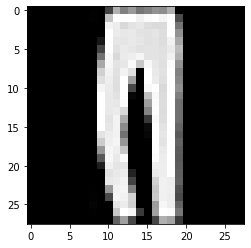

In [69]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

DATASET_ROOT = "/workspace/finn/src/data/fashion"
test_data = torchvision.datasets.FashionMNIST(DATASET_ROOT, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

images, labels = next(iter(testloader))
testImage = images[2]
plt.imshow(testImage.reshape(28,28), cmap='gray')

In [70]:
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_streamlined.onnx")
iname = model.graph.input[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))

import numpy as np
import bitstring
from finn.core.onnx_exec import execute_onnx

test = testImage[0].numpy()*255

input_dict = {iname: test.reshape(ishape)}
ret = execute_onnx(model, input_dict)

classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', \
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

classes[ret["global_out"][0][0]]

Expected network input shape is [1, 1, 28, 28]


'trouser'